In [1]:
# =========================
# Libraries
# =========================

import numpy as np
import pandas as pd
from scipy.integrate import cumulative_trapezoid
from scipy.interpolate import interp1d
import emcee
import multiprocessing as mp
from multiprocessing import pool
from getdist import MCSamples, plots
import matplotlib.pyplot as plt

In [2]:
# =========================
# Loading SNe Ia data (Pantheon+SH0ES)
# =========================

# Path
sne_dat_path = "/home/brunowesley/projetos/MCMC-cosmo/Data/SNe/Pantheon+SH0ES.dat"
sne_cov_path = "/home/brunowesley/projetos/MCMC-cosmo/Data/SNe/Pantheon+SH0ES_STAT+SYS.cov"

# DataFrame
df_sne = pd.read_csv(sne_dat_path, sep=r"\s+", comment="#", engine="python")

# Full statistical + systematic covariance matrix
raw_cov = np.loadtxt(sne_cov_path, skiprows=1)
Cov_sne_full = raw_cov.reshape((1701, 1701))

# Redshift cut to remove very low-z SNe (z <= 0.01)
mask = df_sne["zCMB"].values > 0.01
df_cut = df_sne[mask].reset_index(drop=True)
Cov_sne = Cov_sne_full[mask, :][:, mask]

# Main columns (after redshift cut)
z_sne = df_cut["zCMB"].values
mB_obs = df_cut["m_b_corr"].values

# Inverse covariance matrix
Cinv_sne = np.linalg.inv(Cov_sne)

In [3]:
# ===============================
# Fiducial
# ===============================

# Uniform priors
H0_min, H0_max = 50., 90.
Om0_min, Om0_max = 0.1, 0.6

# Gaussian prior
mu_MB, sigma_MB = -19.24, 0.04

# Physical constant
c_kms = 299792.458

# Cosmological parameter
Or0 = 7.88e-5

# Redshift grid
z_grid = np.linspace(0,2.5,1000)

In [4]:
# ==============================
# Hubble functions
# ==============================

# Normalized Hubble parameter
def E_LCDM(z, Om0):

    # Matter density parameter
    Om = Om0 * (1 + z)**3

    # Radiation density parameter
    Or = Or0 * (1 + z)**4

    # Cosmological constant density
    Ol0 = 1 - Om0 - Or0

    return np.sqrt(Om + Or + Ol0)


# Hubble parameter
def H_LCDM(z, H0, Om0):
    return H0 * E_LCDM(z, Om0)

In [5]:
# ===============================
# Luminosity distance
# ===============================

def dL_LCDM(z, H0, Om0):

    # Hubble parameter
    H_model = H_LCDM(z, H0, Om0)

    # Integrand of the comoving distance: 1/H(z)
    y = 1.0 / H_model

    # Numerical integration from 0 to z
    integral = cumulative_trapezoid(y, z, initial=0.0)

    # Luminosity distance prefactor
    prefactor =  c_kms * (1.0 + z) 

    return z, prefactor * integral


def dL_LCDM_interp(z_points, H0, Om0):

    # Compute the luminosity distance on the predefined redshift grid
    z_model, dL_model = dL_LCDM(z_grid, H0, Om0)

    # Linear interpolation
    f = interp1d(z_model, dL_model, kind="linear", bounds_error=False, fill_value="extrapolate")
    return f(z_points)


# ===============================
# Distance modulus
# ===============================

def mu_LCDM(z_points, H0, Om0):

    # Interpoled luminosity distance
    dL_vals = dL_LCDM_interp(z_points, H0, Om0)

    return 5.0 * np.log10(dL_vals) + 25.0


# ===============================
# Apparent magnitude
# ===============================

def mB_LCDM(z_sne, H0, Om0, MB):
    return mu_LCDM(z_sne, H0, Om0) + MB


# ========================
# Sanity test
# ========================

print("mB_LCDM(z_sne) =", mB_LCDM(z_sne, 72, 0.3, -19.23))

mB_LCDM(z_sne) = [13.94680145 13.99316007 13.99316007 ... 26.38679781 26.54544731
 26.99130486]


In [6]:
# =========================================
# SNe Likelihood (Pantheon+SH0ES)
# =========================================

# Log-priors
def lnprior_sne(theta_sne):

    # Params vector
    H0, Om0, MB = theta_sne
    
    # Flat priors
    if not (H0_min < H0 < H0_max):     return -np.inf
    if not (Om0_min < Om0 < Om0_max):  return -np.inf

    # Gaussian prior on MB
    lp_MB = -0.5 * ((MB - mu_MB)**2 / sigma_MB**2) - np.log(sigma_MB* np.sqrt(2*np.pi))

    return lp_MB


# Log-likelihood
def lnlike_sne(theta_sne, z_sne, mB_obs, Cinv_sne):
    H0, Om0, MB = theta_sne

    # Theoretical apparent magnitude
    mB_model = mB_LCDM(z_sne, H0, Om0, MB)

    # Residual vector
    d = mB_obs - mB_model

    # Chi-squared
    chi2 = np.dot(d, np.dot(Cinv_sne, d))

    return -0.5 * chi2


# Log-posterior
def lnprob_sne(theta_sne, z_sne, mB_obs, Cinv_sne):

    # Log-prior
    lp = lnprior_sne(theta_sne)
    if not np.isfinite(lp):
        return -np.inf
    
    # Log-likelihood
    ll = lnlike_sne(theta_sne, z_sne, mB_obs, Cinv_sne)

    return lp + ll


# =====================
# Quick test
# =====================

theta_test = [72, 0.3, -19.3]
print("LCDM_SNe log-posterior =", lnprob_sne(theta_test, z_sne, mB_obs, Cinv_sne))

LCDM_SNe log-posterior = -721.4800280456823


In [ ]:
# =========================
# MCMC configuration
# =========================

# Dimensions and sampling settings
ndim, nwalkers, nsteps, nburn = 3, 40, 53500, 3500
rng = np.random.default_rng(42)

# Initial walker positions drawn from priors
p0 = np.zeros((nwalkers, ndim))
p0[:,0] = rng.uniform(H0_min, H0_max, size=nwalkers)         # H0 uniforme
p0[:,1] = rng.uniform(Om0_min, Om0_max, size=nwalkers)       # Omega_m0 uniforme
p0[:,2] = rng.normal(mu_MB, sigma_MB, nwalkers)              # MB gaussiano

# Parallel chain generation (LESS efficient for LCDM_SNe)
# with mp.Pool(processes=nwalkers) as pool:
#     sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_sne, args=(z_sne, mB_obs, Cinv_sne), pool=pool)
#     sampler.run_mcmc(p0, nsteps, progress=True)

# Single-threaded chain generation (MORE efficient for LCDM_SNe)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_sne, args=(z_sne, mB_obs, Cinv_sne))
sampler.run_mcmc(p0, nsteps, progress=True)


# Full chain: shape (nsteps, nwalkers, ndim)
chain = sampler.get_chain()
# np.save("chain_sne_LCDM.npy", chain)

# Flattened chain after burn-in: shape (N_total, ndim)
flat_samples = sampler.get_chain(discard=nburn, flat=True)
np.save("flat_samples_sne_LCDM.npy", flat_samples)

100%|██████████| 53500/53500 [08:20<00:00, 106.89it/s]


Removed no burn in


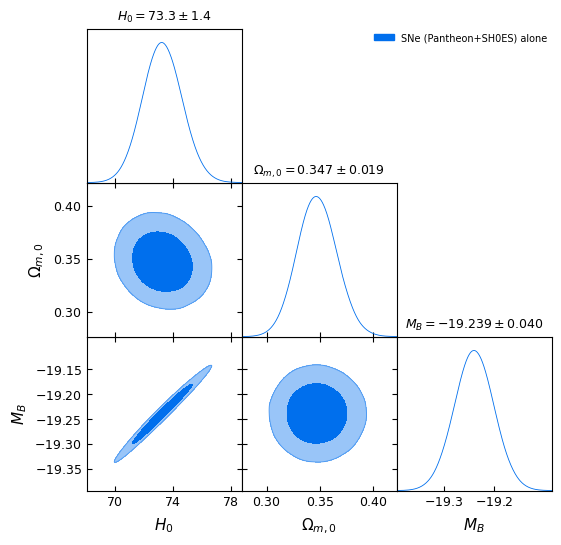

In [8]:
# =========================
# Corner plot using GetDist
# =========================

# Parameter names and LaTeX labels
param_names  = ["H0", "Omega_m0", "MB"]
param_labels = [r"H_0", r"\Omega_{m,0}", r"M_B"]


# Create GetDist samples object
samples = MCSamples(
    samples=flat_samples,
    names=param_names,
    labels=param_labels
)

# Smoothing and binning settings
samples.updateSettings({
    "smooth_scale_1D": 0.25,
    "smooth_scale_2D": 0.25,
    "fine_bins": 1024,
    "fine_bins_2D": 1024

})


# Parameter ranges (optional)
# samples.setRanges({
#     "param p1": (p1_min, p1_max),
#     "param p2": (p2_min, p2_max),
#     "param p3": (p3_min, p3_max)
# })


# Initialize GetDist subplot plotter
g = plots.get_subplot_plotter()

# Plot styling settings
g.settings.axes_fontsize = 12
g.settings.lab_fontsize = 14
g.settings.legend_fontsize = 10
g.settings.linewidth_contour = 1.2
g.settings.num_plot_contours = 2
g.settings.axis_marker_lw = 1.0
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.3


# Triangle (corner) plot
g.triangle_plot(
    samples,
    filled=True,
    legend_labels=["SNe (Pantheon+SH0ES) alone"],
    #contour_colors=["#"],
    title_limit=1
)

# Save figure
plt.savefig("triangle_sne_LCDM.png", dpi=300, bbox_inches="tight")
plt.show()